## Загрузка данных

In [1]:
!rm -r ./data
!mkdir ./data/
!pip install gdown
!cd ./data && gdown --id '1KjjTDXQnwA2G9rMVeKZWPeK3hA7HI3O2'

rm: cannot remove './data': No such file or directory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1KjjTDXQnwA2G9rMVeKZWPeK3hA7HI3O2
To: /content/data/train_random.single.json
100% 786k/786k [00:00<00:00, 99.3MB/s]


In [2]:
file_path = './data/train_random.single.json'

In [3]:
import json
from tqdm import tqdm

In [4]:
responses = []
with open(file_path, 'r') as file:
    for row in tqdm(file):
        resp = json.loads(row)
        responses.append(resp)

2830it [00:00, 133089.80it/s]


In [5]:
responses[10]

{'text': 'I have only 2 episodes left of the {@The Vampire Diaries@} . I’ll probably get to watch them on new years eve. Cant think of a better way to end the decade.',
 'date': '2019-12-30',
 'label': 2,
 'id': 1211494999554215936,
 'label_name': 'pop_culture'}

In [6]:
len(responses)

2830

In [7]:
import pandas as pd

In [8]:
df = pd.DataFrame(responses)
df.head()

,text,date,label,id,label_name
0,Chief Keef - Jumanji (New Music) (Finally Roll...,2020-11-29,2,1333017242246766594,pop_culture
1,Happy Anniversary beautéderm and more years! ...,2021-08-01,3,1421771054318456842,daily_life
2,Ok so I just got home from the club and I real...,2021-06-27,2,1409086728124596228,pop_culture
3,Sooooo.. it s {@PROGRESS Wrestling@} #StillCha...,2019-09-15,4,1173263799949889544,sports_&_gaming
4,#HappyWomensDay2020 If there s one thing for y...,2020-03-08,3,1236618379731120130,daily_life


<Axes: ylabel='Frequency'>

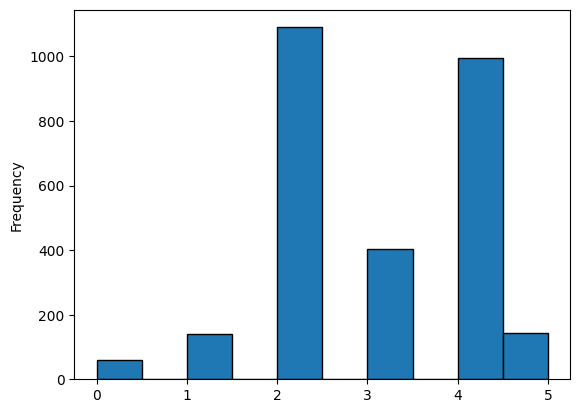

In [9]:
df.label.plot(kind='hist', edgecolor='black')

In [10]:
df.label.value_counts()

2    1090
4     996
3     402
5     143
1     140
0      59
Name: label, dtype: int64

In [11]:
df.label_name.value_counts()

pop_culture                 1090
sports_&_gaming              996
daily_life                   402
science_&_technology         143
business_&_entrepreneurs     140
arts_&_culture                59
Name: label_name, dtype: int64

## Препроцессинг данных

* Удалим из текста все ссылки и теги
* Удалим пунктуацию, числа и whitespaces
* Побьем хэштеги на слова
* Обрежем удлиненные окончания слов
* Лемматизуем текст
* Удалим все токены, которые перечислены в nltk.corpus.stopwords.words('english')

In [12]:
!pip install wordsegment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 48.3 MB/s eta 0:00:00


In [13]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import re
import spacy
from nltk.corpus import stopwords
from wordsegment import load, segment

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [14]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
load()

def split_hashtag(x):
    return ' '.join(segment(x.group(0)))

# function to lemmatize text
def lemmatization(texts):
    output = []
    for text in texts:
        # remove stopwords and not ascii symbols
        s = [token for token in text.split() if token.isascii() and not token in stopwords.words('english')]
        text = ' '.join(s)
        out = [token.lemma_ for token in nlp(text)]
        output.append(' '.join(out))
    return output

def clean_text(df, column):
    # remove URL's and USERNAME's
    df['clean_tweet'] = df[column].apply(lambda x: re.sub(r'\{\{[A-Z]+\}\}', '', x))
    #df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'http\S+', '', x))

    # remove twitter handles (@user)
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r"\{@.+@\}", '', x))
    #df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r"@[^\s]+", '', x))

    # split hashtags
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r"#([^\s]+)", split_hashtag, x))

    # replace / with space
    df['clean_tweet'] = df['clean_tweet'].str.replace("/", " ")

    # remove punctuation marks
    punctuation = '.,\'!"#$%&()*+-:;<=>?@[\\]^_`{|}~'
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

    # convert text to lowercase
    df['clean_tweet'] = df['clean_tweet'].str.lower()

    # remove numbers
    df['clean_tweet'] = df['clean_tweet'].str.replace("[0-9]", " ")

    # remove whitespaces
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x:' '.join(x.split()))

    # strip words with 3 or more letters in the end
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r"([a-z])\1{2,}", r"\1", x))

    #normalize the words to its base form
    df['clean_tweet'] = lemmatization(df['clean_tweet'])

In [15]:
clean_text(df, 'text')

<ipython-input-14-ef11f38371ad>:41: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_tweet'] = df['clean_tweet'].str.replace("[0-9]", " ")


In [16]:
df.text[4]

'#HappyWomensDay2020 If there s one thing for you girls and women out there to read/listen to/watch as you are marking this special day, then I very much recommend this {{USERNAME}}  s Facebook post {{URL}} '

In [17]:
df.clean_tweet[4]

'happy woman sday one thing girl woman read listen watch mark special day much recommend facebook post'

In [18]:
df.head()

,text,date,label,id,label_name,clean_tweet
0,Chief Keef - Jumanji (New Music) (Finally Roll...,2020-11-29,2,1333017242246766594,pop_culture,chief keef jumanji new music finally rollin mu...
1,Happy Anniversary beautéderm and more years! ...,2021-08-01,3,1421771054318456842,daily_life,happy anniversary year bd th anniversary ruru ...
2,Ok so I just got home from the club and I real...,2021-06-27,2,1409086728124596228,pop_culture,ok get home club realize lgbtq community play ...
3,Sooooo.. it s {@PROGRESS Wrestling@} #StillCha...,2019-09-15,4,1173263799949889544,sports_&_gaming,vs yes
4,#HappyWomensDay2020 If there s one thing for y...,2020-03-08,3,1236618379731120130,daily_life,happy woman sday one thing girl woman read lis...


In [19]:
df.shape

(2830, 6)

In [20]:
df = df[df.clean_tweet != '']
df.shape

(2826, 6)

In [21]:
df.to_csv('tweets.csv', index=False)

## LDA (Latent Dirichlet Allocation)

In [22]:
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import models

In [23]:
# токенизация

tokens = []

for tweet in df['clean_tweet']:
    tokens.append(tweet.split())

In [24]:
dictionary = gensim.corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000) # фильтруем данные

bow_corpus = [dictionary.doc2bow(doc) for doc in tokens] # первый корпус - BOW

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus] # второй корпус - tfidf

In [25]:
# обучаем модель сначала на BOW

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=dictionary, passes=2, workers=2)

В нашем датасете **6** топиков, поэтому мы просим модель выделить тоже **6** топиков.

In [26]:
for idx, topic in lda_model.print_topics():
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.055*"via" + 0.018*"make" + 0.015*"game" + 0.012*"live" + 0.012*"go" + 0.011*"come" + 0.011*"watch" + 0.011*"need" + 0.011*"say" + 0.010*"good"
Topic: 1 
Words: 0.032*"new" + 0.029*"music" + 0.025*"via" + 0.018*"like" + 0.017*"go" + 0.016*"please" + 0.015*"stream" + 0.015*"video" + 0.013*"tell" + 0.011*"listen"
Topic: 2 
Words: 0.022*"time" + 0.021*"come" + 0.018*"think" + 0.016*"see" + 0.016*"back" + 0.015*"game" + 0.014*"look" + 0.014*"good" + 0.014*"get" + 0.013*"one"
Topic: 3 
Words: 0.023*"new" + 0.020*"love" + 0.017*"like" + 0.017*"music" + 0.015*"good" + 0.013*"we" + 0.013*"great" + 0.013*"year" + 0.012*"play" + 0.011*"last"
Topic: 4 
Words: 0.024*"get" + 0.017*"go" + 0.016*"state" + 0.014*"love" + 0.012*"well" + 0.012*"first" + 0.012*"game" + 0.012*"watch" + 0.012*"video" + 0.010*"one"
Topic: 5 
Words: 0.036*"day" + 0.025*"via" + 0.019*"love" + 0.018*"year" + 0.017*"happy" + 0.016*"new" + 0.014*"time" + 0.012*"get" + 0.010*"game" + 0.010*"one"


Пробуем интерпретировать выделенные моделью топики:

0.   --
1.   музыка и видео
2.   --
3.   музыка и игры
4.   спорт (самая очевидная из всех)
5.   повседневная жизнь ?





In [27]:
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))

coherence_model_lda = models.CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.213453897136644

Coherence Score:  0.27212956587243126


In [28]:
# обучаем модель на tfidf

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=6, id2word=dictionary, passes=2, workers=4)

In [29]:
for idx, topic in lda_model_tfidf.print_topics():
    print('Topic: {} \nWord: {}'.format(idx, topic))

Topic: 0 
Word: 0.018*"video" + 0.016*"music" + 0.015*"love" + 0.015*"via" + 0.013*"official" + 0.010*"back" + 0.009*"day" + 0.008*"great" + 0.008*"really" + 0.008*"give"
Topic: 1 
Word: 0.014*"go" + 0.013*"new" + 0.011*"make" + 0.010*"fight" + 0.010*"song" + 0.010*"music" + 0.010*"via" + 0.009*"stream" + 0.009*"get" + 0.009*"th"
Topic: 2 
Word: 0.028*"via" + 0.015*"music" + 0.014*"new" + 0.011*"like" + 0.010*"check" + 0.008*"dance" + 0.008*"see" + 0.007*"album" + 0.007*"spotify" + 0.007*"news"
Topic: 3 
Word: 0.018*"game" + 0.013*"play" + 0.010*"vs" + 0.010*"series" + 0.010*"get" + 0.010*"take" + 0.009*"watch" + 0.009*"team" + 0.008*"time" + 0.008*"go"
Topic: 4 
Word: 0.016*"via" + 0.013*"make" + 0.012*"new" + 0.012*"day" + 0.009*"love" + 0.009*"stay" + 0.009*"woman" + 0.009*"year" + 0.008*"good" + 0.008*"night"
Topic: 5 
Word: 0.016*"happy" + 0.014*"via" + 0.013*"day" + 0.013*"new" + 0.012*"come" + 0.012*"year" + 0.011*"love" + 0.011*"watch" + 0.010*"look" + 0.009*"see"


Пробуем интерпретировать выделенные моделью топики:

0.   игры ?
1.   музыка и видео
2.   музыка ?
3.   --
4.   музыка и видео
5.   --





In [30]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus_tfidf))

coherence_model_lda = models.CoherenceModel(model=lda_model_tfidf, texts=tokens, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.323233277764999

Coherence Score:  0.2516807659886172


Проверяем, к какой теме модели отнесут первый твит в датасете.

In [31]:
df['text'][0]

'Chief Keef - Jumanji (New Music) (Finally Rollin 2) (Music Video) {{URL}} via {{USERNAME}} {@Glory Boy@} U2BEJUMANJI €!M[]dzAx!sWallHackAimBot€ DamagedModz247 MYNAMEISSCREAM THOTBREAKER'

In [32]:
for index, score in sorted(lda_model[bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.7942487001419067	 
Topic: 0.032*"new" + 0.029*"music" + 0.025*"via" + 0.018*"like" + 0.017*"go" + 0.016*"please" + 0.015*"stream" + 0.015*"video" + 0.013*"tell" + 0.011*"listen"

Score: 0.13090434670448303	 
Topic: 0.024*"get" + 0.017*"go" + 0.016*"state" + 0.014*"love" + 0.012*"well" + 0.012*"first" + 0.012*"game" + 0.012*"watch" + 0.012*"video" + 0.010*"one"

Score: 0.01877453550696373	 
Topic: 0.055*"via" + 0.018*"make" + 0.015*"game" + 0.012*"live" + 0.012*"go" + 0.011*"come" + 0.011*"watch" + 0.011*"need" + 0.011*"say" + 0.010*"good"

Score: 0.01875627040863037	 
Topic: 0.036*"day" + 0.025*"via" + 0.019*"love" + 0.018*"year" + 0.017*"happy" + 0.016*"new" + 0.014*"time" + 0.012*"get" + 0.010*"game" + 0.010*"one"

Score: 0.018676448613405228	 
Topic: 0.023*"new" + 0.020*"love" + 0.017*"like" + 0.017*"music" + 0.015*"good" + 0.013*"we" + 0.013*"great" + 0.013*"year" + 0.012*"play" + 0.011*"last"

Score: 0.018639732152223587	 
Topic: 0.022*"time" + 0.021*"come" + 0.018*"thin

In [33]:
for index, score in sorted(lda_model_tfidf[bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.9064677953720093	 
Topic: 0.014*"go" + 0.013*"new" + 0.011*"make" + 0.010*"fight" + 0.010*"song" + 0.010*"music" + 0.010*"via" + 0.009*"stream" + 0.009*"get" + 0.009*"th"

Score: 0.018777726218104362	 
Topic: 0.016*"happy" + 0.014*"via" + 0.013*"day" + 0.013*"new" + 0.012*"come" + 0.012*"year" + 0.011*"love" + 0.011*"watch" + 0.010*"look" + 0.009*"see"

Score: 0.01876189559698105	 
Topic: 0.028*"via" + 0.015*"music" + 0.014*"new" + 0.011*"like" + 0.010*"check" + 0.008*"dance" + 0.008*"see" + 0.007*"album" + 0.007*"spotify" + 0.007*"news"

Score: 0.01875392347574234	 
Topic: 0.018*"video" + 0.016*"music" + 0.015*"love" + 0.015*"via" + 0.013*"official" + 0.010*"back" + 0.009*"day" + 0.008*"great" + 0.008*"really" + 0.008*"give"

Score: 0.01864679716527462	 
Topic: 0.016*"via" + 0.013*"make" + 0.012*"new" + 0.012*"day" + 0.009*"love" + 0.009*"stay" + 0.009*"woman" + 0.009*"year" + 0.008*"good" + 0.008*"night"

Score: 0.01859179139137268	 
Topic: 0.018*"game" + 0.013*"play" + 0.0

С большой вероятностью тема твита определяется как что-то, связанное с музыкой, что в принципе является правдой.

### Вывод
Как видно, темы интерпретируются сложно, модель почти не обладает эффективностью.

## PLSA (Probabilistic Latent Semantic Analysis)

In [34]:
!pip install plsa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
from plsa import Corpus, Pipeline, Visualize
from plsa.pipeline import DEFAULT_PIPELINE
from plsa.algorithms import PLSA
import matplotlib.pyplot as plt

В этом модуле есть свой препроцессинг, поэтому после обработки остается меньше текстов, чем в нашем изначальном датасете.

In [36]:
pipeline = Pipeline(*DEFAULT_PIPELINE)
corpus = Corpus.from_csv('tweets.csv', pipeline)

In [37]:
n_topics = 6
plsa = PLSA(corpus, n_topics, True)
plsa

PLSA:
====
Number of topics:     6
Number of documents:  997
Number of words:      3080
Number of iterations: 0

In [38]:
result = plsa.best_of(5)

In [39]:
result.word_given_topic[0][:10] # первые 10 слов 1 топика

(('home', 0.008531708736585555),
 ('series', 0.007510330509536077),
 ('team', 0.0072676457714738974),
 ('year', 0.006879733526112585),
 ('decade', 0.0068048173685762575),
 ('talk', 0.006663880513206482),
 ('watch', 0.006436976322333876),
 ('music', 0.006241730091988233),
 ('news', 0.006033615072038604),
 ('night', 0.005994285789145865))

In [40]:
result.word_given_topic[1][:10] # первые 10 слов 2 топика

(('hour', 0.011341904217248207),
 ('song', 0.009630875184914933),
 ('power', 0.009120145122791957),
 ('today', 0.005928021360724471),
 ('watch', 0.0059140823205904546),
 ('year', 0.0058841458039555015),
 ('game', 0.005571473234723417),
 ('student', 0.005398660854897746),
 ('league', 0.005156530828871204),
 ('delay', 0.005001997649646517))

In [41]:
result.word_given_topic[2][:10] # первые 10 слов 3 топика

(('easter', 0.010296325434049756),
 ('fan', 0.00863994437490401),
 ('game', 0.007554206309802173),
 ('weekend', 0.006546486986628167),
 ('bowl', 0.006252550262634679),
 ('music', 0.006128205142231848),
 ('tomorrow', 0.006116328005703197),
 ('winner', 0.006105386118789147),
 ('guy', 0.006037811107763359),
 ('day', 0.005871799008094192))

In [42]:
result.word_given_topic[3][:10] # первые 10 слов 4 топика

(('dance', 0.01036145529810119),
 ('permission', 0.009440263289799376),
 ('sugar', 0.009440263289799376),
 ('let', 0.008750069427525228),
 ('watermelon', 0.008276902004342473),
 ('music', 0.007784445626230946),
 ('video', 0.0069851958351861854),
 ('style', 0.006362941371806195),
 ('official', 0.005892963184861779),
 ('head', 0.005669396170332838))

In [43]:
result.word_given_topic[4][:10] # первые 10 слов 5 топика

# спорт

(('break', 0.008585984968748468),
 ('fury', 0.007192514213956938),
 ('love', 0.006845374225376894),
 ('family', 0.0065246183430946215),
 ('stream', 0.0064583325928468235),
 ('relief', 0.006153255619294451),
 ('thank', 0.005742022767119806),
 ('fire', 0.005683355885636203),
 ('day', 0.005338515166017912),
 ('copy', 0.005203081375730401))

In [44]:
result.word_given_topic[5][:10] # первые 10 слов 6 топика

(('boy', 0.008773700903915828),
 ('closet', 0.0072772392571136164),
 ('line', 0.007246835291082579),
 ('album', 0.006527256549565435),
 ('vote', 0.005901196993142925),
 ('matter', 0.005894509299667834),
 ('box', 0.005885182805887481),
 ('state', 0.005468167008297965),
 ('direction', 0.005271698105232045),
 ('music', 0.005097426627391124))

In [45]:
# можно посмотреть, к какому топику модель относит каждый твит

result.topic_given_doc[0]

array([1., 0., 0., 0., 0., 0.])

## FastText Classifier

In [46]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393157 sha256=b6c792bb6289ca521409f5e3f7e2db22125d2fbf04a9c00a37431a6110c92992
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [47]:
import fasttext

In [48]:
labels = []
for i in df['label']:
  labels.append('__label__' + str(i))

texts = []
for tweet in df['clean_tweet']:
  texts.append(tweet)

In [49]:
df_train = pd.DataFrame({'label': labels[:2500], 'texts': texts[:2500]})
df_test = pd.DataFrame({'label': labels[2500:], 'texts': texts[2500:]})

df_train.to_csv('FT_train.csv', sep=' ', header=False, index=False)
df_test.to_csv('FT_test.csv', sep=' ', header=False, index=False)

In [50]:
model = fasttext.train_supervised(input="FT_train.csv")

In [51]:
model.test("FT_test.csv")

(326, 0.5920245398773006, 0.5920245398773006)

In [52]:
model = fasttext.train_supervised(input="FT_train.csv", epoch=35, lr=1.0)

In [53]:
model.test("FT_test.csv")

(326, 0.696319018404908, 0.696319018404908)

In [54]:
model = fasttext.train_supervised(input="FT_train.csv", epoch=35, lr=1.0, wordNgrams=3)

In [55]:
model.test("FT_test.csv")

(326, 0.6656441717791411, 0.6656441717791411)

Лучший результат ниже:

In [56]:
model = fasttext.train_supervised(input="FT_train.csv", epoch=35)

In [57]:
preds = []

for i in df_test['texts']:
  preds.append(model.predict(i)[0][0])

In [62]:
from sklearn.metrics import accuracy_score, f1_score

In [60]:
accuracy_score(df_test['label'], preds)

0.6993865030674846

In [63]:
f1_score(df_test['label'], preds, average='weighted')

0.6841123623146206

In [64]:
model.test("FT_test.csv")

(326, 0.7239263803680982, 0.7239263803680982)

## SVC

In [65]:
X = df.clean_tweet.values
y = df.label.values

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [67]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(encoding='utf8', min_df=5)
X_train = vectorizer.fit_transform(X_train)
X_train.shape

(1978, 1019)

In [68]:
X_test = vectorizer.transform(X_test)
X_test.shape

(848, 1019)

In [69]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')

In [70]:
svc.fit(X_train, y_train)

SVC(kernel='linear')

In [71]:
y_pred_svc = svc.predict(X_test)

In [72]:
accuracy_score(y_test, y_pred_svc)

0.6709905660377359

In [73]:
f1_score(y_test, y_pred_svc, average='weighted')

0.6663705403640381

## Логистическая регрессия

In [74]:
X = df.clean_tweet.values
y = df.label.values

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [76]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(encoding='utf8', min_df=5)
X_train = vectorizer.fit_transform(X_train)
X_train.shape

(1978, 1019)

In [77]:
y_train.shape

(1978,)

In [78]:
X_test = vectorizer.transform(X_test)
X_test.shape

(848, 1019)

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import numpy as np

model = LogisticRegression(solver='liblinear', random_state=0).fit(X_train, y_train)
preds = model.predict_proba(X_test)
print('ROC-AUC: %.3f, ACC: %.3f, F1: %.3f' % (roc_auc_score(y_test, preds, multi_class='ovr'),
                         accuracy_score(y_test, np.argmax(preds, axis=1)),
                         f1_score(y_test, np.argmax(preds, axis=1), average='weighted')))

ROC-AUC: 0.875, ACC: 0.721, F1: 0.708


In [80]:
df.label.value_counts()

2    1088
4     994
3     402
5     143
1     140
0      59
Name: label, dtype: int64

In [81]:
df.label_name.value_counts()

pop_culture                 1088
sports_&_gaming              994
daily_life                   402
science_&_technology         143
business_&_entrepreneurs     140
arts_&_culture                59
Name: label_name, dtype: int64

Веса для arts_&_culture

In [82]:
f_weights = zip(vectorizer.get_feature_names_out(), model.coef_[0])
f_weights = sorted(f_weights, key=lambda i: i[1])
for i in range(1,30):
    print('%s, %.2f' % f_weights[-i])

print('...')
for i in reversed(range(1,30)):
    print('%s, %.2f' % f_weights[i])

art, 1.82
dead, 1.40
jesus, 1.16
god, 1.13
free, 1.05
solstice, 1.03
celebrate, 1.03
saint, 1.02
book, 1.01
perfect, 1.01
read, 1.01
winter, 0.97
dance, 0.95
present, 0.94
artist, 0.92
place, 0.87
faith, 0.84
reason, 0.82
crypto, 0.79
gift, 0.78
article, 0.76
girl, 0.75
light, 0.71
fire, 0.69
sometimes, 0.69
easter, 0.67
meet, 0.66
wind, 0.65
figure, 0.65
...
star, -0.41
run, -0.41
dinner, -0.42
season, -0.42
next, -0.43
watch, -0.45
show, -0.47
find, -0.47
sister, -0.48
start, -0.48
lot, -0.48
moment, -0.49
album, -0.49
ufc, -0.50
keep, -0.51
long, -0.51
use, -0.52
end, -0.53
permission, -0.57
team, -0.58
song, -0.61
back, -0.61
get, -0.63
hope, -0.65
win, -0.66
game, -0.69
video, -0.72
music, -0.81
good, -0.81


Веса для business_&_entrepreneurs

In [83]:
f_weights = zip(vectorizer.get_feature_names_out(), model.coef_[1])
f_weights = sorted(f_weights, key=lambda i: i[1])
for i in range(1,30):
    print('%s, %.2f' % f_weights[-i])

print('...')
for i in reversed(range(1,30)):
    print('%s, %.2f' % f_weights[i])

stock, 2.08
bank, 1.98
business, 1.96
company, 1.76
extra, 1.46
money, 1.44
marketing, 1.35
market, 1.32
problem, 1.22
crypto, 1.21
project, 1.05
hand, 1.01
worldwide, 0.97
sell, 0.94
east, 0.93
important, 0.92
opening, 0.92
support, 0.92
link, 0.85
dear, 0.84
long, 0.83
announce, 0.81
pass, 0.80
buy, 0.79
gas, 0.79
research, 0.77
june, 0.76
sign, 0.75
surprise, 0.75
...
fire, -0.53
state, -0.53
next, -0.53
great, -0.54
power, -0.54
final, -0.55
st, -0.55
football, -0.56
amazing, -0.56
action, -0.56
go, -0.57
watch, -0.57
wait, -0.58
cancel, -0.60
woman, -0.60
tonight, -0.60
video, -0.64
good, -0.67
war, -0.67
well, -0.68
family, -0.68
ufc, -0.73
song, -0.73
season, -0.74
white, -0.74
bad, -0.77
work, -0.79
album, -0.79
game, -1.00


Веса для pop_culture

In [84]:
f_weights = zip(vectorizer.get_feature_names_out(), model.coef_[2])
f_weights = sorted(f_weights, key=lambda i: i[1])
for i in range(1,30):
    print('%s, %.2f' % f_weights[-i])

print('...')
for i in reversed(range(1,30)):
    print('%s, %.2f' % f_weights[i])

music, 2.87
album, 2.84
song, 2.59
movie, 2.22
harry, 1.68
mandalorian, 1.61
listen, 1.50
mr, 1.48
film, 1.42
channel, 1.34
voice, 1.34
vote, 1.34
tune, 1.25
episode, 1.25
thankful, 1.20
concert, 1.20
actor, 1.20
lil, 1.18
permission, 1.17
radio, 1.14
queen, 1.14
star, 1.12
later, 1.11
bts, 1.10
land, 1.08
nominate, 1.08
laugh, 1.07
spotify, 1.05
bt, 1.04
...
league, -0.94
god, -0.95
extra, -0.96
vs, -0.98
team, -1.00
sister, -1.00
playoff, -1.02
money, -1.02
family, -1.02
gaming, -1.03
crypto, -1.04
cowboy, -1.05
player, -1.06
winter, -1.08
top, -1.08
goal, -1.10
covid, -1.10
help, -1.10
football, -1.12
coach, -1.13
protect, -1.14
bowl, -1.20
state, -1.22
main, -1.23
cup, -1.34
girl, -1.36
sport, -1.42
fight, -1.49
ufc, -1.99


Веса для daily_life

In [85]:
f_weights = zip(vectorizer.get_feature_names_out(), model.coef_[3])
f_weights = sorted(f_weights, key=lambda i: i[1])
for i in range(1,30):
    print('%s, %.2f' % f_weights[-i])

print('...')
for i in reversed(range(1,30)):
    print('%s, %.2f' % f_weights[i])

sister, 2.03
message, 1.64
family, 1.49
dinner, 1.41
bar, 1.38
summer, 1.35
happy, 1.31
sleep, 1.31
morning, 1.21
woman, 1.17
moment, 1.13
enter, 1.12
hour, 1.10
father, 1.09
meal, 1.06
coronavirus, 1.05
help, 1.04
meeting, 1.03
might, 1.03
remember, 1.02
christmas, 1.00
box, 0.95
baby, 0.95
strong, 0.95
avoid, 0.94
protest, 0.94
lovely, 0.93
blame, 0.92
ny, 0.92
...
company, -0.73
character, -0.74
virtual, -0.74
round, -0.74
series, -0.75
internet, -0.75
voice, -0.76
card, -0.77
vs, -0.77
face, -0.78
star, -0.80
tv, -0.81
win, -0.82
control, -0.83
south, -0.83
fall, -0.87
watch, -0.88
second, -0.88
long, -0.90
brown, -0.96
ufc, -1.00
story, -1.04
movie, -1.12
still, -1.15
fan, -1.17
game, -1.33
album, -1.34
song, -1.38
music, -1.48


Веса для sports_&_gaming

In [86]:
f_weights = zip(vectorizer.get_feature_names_out(), model.coef_[4])
f_weights = sorted(f_weights, key=lambda i: i[1])
for i in range(1,30):
    print('%s, %.2f' % f_weights[-i])

print('...')
for i in reversed(range(1,30)):
    print('%s, %.2f' % f_weights[i])

ufc, 2.82
game, 2.78
sport, 1.91
coach, 1.83
football, 1.71
cup, 1.68
nfl, 1.58
player, 1.54
bowl, 1.50
gaming, 1.47
team, 1.40
playoff, 1.39
league, 1.30
vs, 1.27
state, 1.26
cowboy, 1.25
xfl, 1.24
fight, 1.23
chief, 1.22
draft, 1.21
nba, 1.19
england, 1.18
win, 1.18
field, 1.17
loss, 1.14
round, 1.14
tournament, 1.13
manchester, 1.11
victory, 1.09
...
pass, -0.85
stay, -0.86
vote, -0.87
love, -0.87
star, -0.90
land, -0.90
celebrate, -0.90
easter, -0.90
mandalorian, -0.93
sister, -0.94
mask, -0.96
film, -0.96
light, -0.97
machine, -0.97
channel, -0.99
share, -1.01
bt, -1.02
video, -1.03
happy, -1.04
book, -1.07
try, -1.13
climate, -1.13
harry, -1.14
house, -1.15
woman, -1.22
listen, -1.23
movie, -1.35
song, -1.64
album, -1.77


Веса для science_&_technology

In [87]:
f_weights = zip(vectorizer.get_feature_names_out(), model.coef_[5])
f_weights = sorted(f_weights, key=lambda i: i[1])
for i in range(1,30):
    print('%s, %.2f' % f_weights[-i])

print('...')
for i in reversed(range(1,30)):
    print('%s, %.2f' % f_weights[i])

climate, 2.22
human, 1.76
learn, 1.69
internet, 1.67
datum, 1.58
vaccine, 1.56
covid, 1.40
change, 1.39
system, 1.32
dark, 1.15
science, 1.10
storm, 1.09
stop, 1.00
energy, 0.96
solid, 0.94
dr, 0.94
age, 0.92
almost, 0.85
second, 0.83
area, 0.82
app, 0.82
minute, 0.80
phone, 0.80
control, 0.80
training, 0.80
shoot, 0.79
daily, 0.78
issue, 0.77
research, 0.77
...
let, -0.56
weekend, -0.56
leave, -0.56
still, -0.56
everyone, -0.56
great, -0.57
offer, -0.58
night, -0.60
th, -0.60
good, -0.60
listen, -0.61
official, -0.61
go, -0.61
vs, -0.63
online, -0.64
not, -0.64
perfect, -0.65
harry, -0.66
bank, -0.66
album, -0.69
win, -0.71
song, -0.74
break, -0.75
play, -0.75
season, -0.77
line, -0.77
game, -0.86
ufc, -0.87
love, -1.12


## DecisionTree

In [88]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

In [89]:
preds = tree.predict_proba(X_test)
print('ROC-AUC: %.3f, ACC: %.3f, F1: %.3f' % (roc_auc_score(y_test, preds, multi_class='ovr'),
                         accuracy_score(y_test, np.argmax(preds, axis=1)),
                         f1_score(y_test, np.argmax(preds, axis=1), average='weighted')))

ROC-AUC: 0.601, ACC: 0.435, F1: 0.330


In [90]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(DecisionTreeClassifier(random_state=241),
                  param_grid={'max_depth': [2, 4, 6, 8, 10],
                              'min_samples_leaf': [1, 5, 10, 15, 20],
                              'criterion': ['gini', 'entropy']},
                  cv=3,
                  scoring='r2')
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=241),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_leaf': [1, 5, 10, 15, 20]},
             scoring='r2')

In [91]:
print(gs.best_score_)
print(gs.best_params_)

-0.1909098391445665
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 20}


In [92]:
# Точность лучшей модели
preds = gs.best_estimator_.predict_proba(X_test)

print('ROC-AUC: %.3f, ACC: %.3f, F1: %.3f' % (roc_auc_score(y_test, preds, multi_class='ovr'),
                         accuracy_score(y_test, np.argmax(preds, axis=1)),
                         f1_score(y_test, np.argmax(preds, axis=1), average='weighted')))

ROC-AUC: 0.691, ACC: 0.532, F1: 0.479


## RandomForest

In [93]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [94]:
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)
preds = forest.predict_proba(X_test)

print('ROC-AUC: %.3f, ACC: %.3f, F1: %.3f' % (roc_auc_score(y_test, preds, multi_class='ovr'),
                         accuracy_score(y_test, np.argmax(preds, axis=1)),
                         f1_score(y_test, np.argmax(preds, axis=1), average='weighted')))

ROC-AUC: 0.849, ACC: 0.698, F1: 0.676


In [95]:
forest = RandomForestClassifier(n_estimators=1000, random_state=0)
forest.fit(X_train, y_train)
preds = forest.predict_proba(X_test)

print('ROC-AUC: %.3f, ACC: %.3f, F1: %.3f' % (roc_auc_score(y_test, preds, multi_class='ovr'),
                         accuracy_score(y_test, np.argmax(preds, axis=1)),
                         f1_score(y_test, np.argmax(preds, axis=1), average='weighted')))

ROC-AUC: 0.852, ACC: 0.693, F1: 0.669


In [ ]:
gs = GridSearchCV(RandomForestClassifier(random_state=241),
                  param_grid={'n_estimators': [100, 1000, 5000],
                              'max_depth': [2, 4, 6, 8, 10],
                              'min_samples_leaf': [1, 5, 10, 15, 20],
                              'criterion': ['gini', 'entropy']},
                  cv=3,
                  scoring='r2')
gs.fit(X_train, y_train)

In [ ]:
print(gs.best_score_)
print(gs.best_params_)

0.022676199495509586
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 1000}


In [ ]:
# Точность лучшей модели
preds = gs.best_estimator_.predict_proba(X_test)

print('ROC-AUC: %.3f, ACC: %.3f, F1: %.3f' % (roc_auc_score(y_test, preds, multi_class='ovr'),
                         accuracy_score(y_test, np.argmax(preds, axis=1)),
                         f1_score(y_test, np.argmax(preds, axis=1), average='weighted')))

ROC AUC на трейне: 0.915
ROC AUC на тесте: 0.859


## Gradient Boosting

In [97]:
boosting = GradientBoostingClassifier(n_estimators=100, random_state=0)
boosting.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [98]:
preds = boosting.predict_proba(X_test)
print('ROC-AUC: %.3f, ACC: %.3f, F1: %.3f' % (roc_auc_score(y_test, preds, multi_class='ovr'),
                         accuracy_score(y_test, np.argmax(preds, axis=1)),
                         f1_score(y_test, np.argmax(preds, axis=1), average='weighted')))

ROC-AUC: 0.872, ACC: 0.696, F1: 0.683


In [99]:
boosting = GradientBoostingClassifier(n_estimators=1000, random_state=0)
boosting.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=1000, random_state=0)

In [100]:
preds = boosting.predict_proba(X_test)
print('ROC-AUC: %.3f, ACC: %.3f, F1: %.3f' % (roc_auc_score(y_test, preds, multi_class='ovr'),
                         accuracy_score(y_test, np.argmax(preds, axis=1)),
                         f1_score(y_test, np.argmax(preds, axis=1), average='weighted')))

ROC-AUC: 0.881, ACC: 0.700, F1: 0.686


In [ ]:
boosting = GradientBoostingClassifier(n_estimators=5000, random_state=0)
boosting.fit(X_train, y_train)

In [ ]:
preds = boosting.predict_proba(X_test)
print('ROC-AUC: %.3f, ACC: %.3f, F1: %.3f' % (roc_auc_score(y_test, preds, multi_class='ovr'),
                         accuracy_score(y_test, np.argmax(preds, axis=1)),
                         f1_score(y_test, np.argmax(preds, axis=1), average='weighted')))

ROC-AUC: 0.852, ACC: 0.688


In [ ]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10, 100, 1000]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.best_params_)

# Точность лучшей модели
preds = clf.predict_proba(X_test)

print('ROC-AUC: %.3f, ACC: %.3f, F1: %.3f' % (roc_auc_score(y_test, preds, multi_class='ovr'),
                         accuracy_score(y_test, np.argmax(preds, axis=1)),
                         f1_score(y_test, np.argmax(preds, axis=1), average='weighted')))